In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) 

transfer learning and train resnet152v2 model on case 1: Real images only

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.applications.resnet_v2 import ResNet152V2, preprocess_input
from keras.optimizers import Adam
from keras.regularizers import l2

base_dir = 'C:/brain_tumor/version2/notebook/Training'
class_names = ['glioma', 'meningioma', 'pituitary']

X = []
y = []

for label, class_name in enumerate(class_names):
    class_dir = os.path.join(base_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

X = X.astype('float32') / 255.0

base_model = ResNet152V2(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.6)(x)  
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

X_final, X_val, y_final, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(
    X_final, y_final,
    epochs=100,
    validation_data=(X_val, y_val),
    batch_size=4
)

In [ ]:
model.save('resnet_case_1.h5')

In [ ]:
# plot accuracy and loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

transfer learning and train resnet152v2 model on case 2: Real images and data augmentation methods

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.applications.resnet_v2 import ResNet152V2, preprocess_input
from keras.optimizers import Adam
from keras.regularizers import l2

base_dir = 'C:/brain_tumor/version2/notebook/Training'
class_names = ['glioma', 'meningioma', 'pituitary']

X = []
y = []

for label, class_name in enumerate(class_names):
    class_dir = os.path.join(base_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

X = X.astype('float32') / 255.0

# Data augmentation setup
datagen = ImageDataGenerator(horizontal_flip=True, height_shift_range=0.2, zoom_range=0.2)

# Generate 200 augmented images for each class
X_augmented = []
y_augmented = []
for class_name in class_names:
    class_idx = class_names.index(class_name)
    class_images = X[y == class_idx]
    class_labels = y[y == class_idx]
    
    augmented_images = datagen.flow(class_images, class_labels, batch_size=1, shuffle=False)
    
    for _ in range(200):
        aug_img, aug_label = augmented_images.next()
        X_augmented.append(aug_img[0])
        y_augmented.append(aug_label[0])

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

X_combined = np.concatenate((X, X_augmented), axis=0)
y_combined = np.concatenate((y, y_augmented), axis=0)

X_final, X_val, y_final, y_val = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

base_model = ResNet152V2(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.6)(x)  
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_final, y_final,
    epochs=100,
    validation_data=(X_val, y_val),
    batch_size=4
)

In [ ]:
model.save('resnet_case_2.h5')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

transfer learning and train resnet152v2 model on case 3: Real images and generated images

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.applications.resnet_v2 import ResNet152V2, preprocess_input
from keras.optimizers import Adam
from keras.regularizers import l2

base_dir = 'C:/brain_tumor/version2/notebook/Training'
gen_dir = 'C:/brain_tumor/version2/notebook/generated_dataset'
class_names = ['glioma', 'meningioma', 'pituitary']

X = []
y = []
X_generated = []
y_generated = []

for label, class_name in enumerate(class_names):
    class_dir = os.path.join(base_dir, class_name)
    gen_class_dir = os.path.join(gen_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))
        X.append(img)
        y.append(label)
    for image_name in os.listdir(gen_class_dir):
        image_path = os.path.join(gen_class_dir, image_name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (128, 128))
        X_generated.append(image)
        y_generated.append(label)

X = np.array(X)
y = np.array(y)
X_generated = np.array(X_generated)
y_generated = np.array(y_generated)

X = X.astype('float32') / 255.0
X_generated = X_generated.astype('float32') / 255.0

X_train_combined = np.concatenate((X, X_generated), axis=0)
y_train_combined = np.concatenate((y, y_generated), axis=0)

shuffle_indices = np.random.permutation(len(X_train_combined))
X_train_combined_shuffled = X_train_combined[shuffle_indices]
y_train_combined_shuffled = y_train_combined[shuffle_indices]

base_model = ResNet152V2(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.6)(x)  
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

X_final, X_val, y_final, y_val = train_test_split(X_train_combined_shuffled, y_train_combined_shuffled, test_size=0.2, random_state=42)

model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_final, y_final,
    epochs=100,
    validation_data=(X_val, y_val),
    batch_size=4
)

In [ ]:
model.save('resnet_case_3.h5')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Below code blocks are just my testing process

In [2]:
# import os
# import cv2
# import numpy as np
# from sklearn.model_selection import train_test_split
# import tensorflow as tf
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
# from keras.applications.resnet_v2 import ResNet152V2, preprocess_input
# from keras.optimizers import Adam
# from keras.regularizers import l2

# base_dir = 'C:/brain_tumor/version2/notebook/classify_dataset'
# class_names = ['glioma', 'meningioma', 'pituitary']

# X = []
# y = []

# for label, class_name in enumerate(class_names):
#     class_dir = os.path.join(base_dir, class_name)
#     for img_name in os.listdir(class_dir):
#         img_path = os.path.join(class_dir, img_name)
#         img = cv2.imread(img_path)
#         img = cv2.resize(img, (128, 128))
#         X.append(img)
#         y.append(label)

# X = np.array(X)
# y = np.array(y)

# X = X.astype('float32') / 255.0

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train = np.array([preprocess_input(cv2.resize(img, (128, 128))) for img in X_train])
# X_test = np.array([preprocess_input(cv2.resize(img, (128, 128))) for img in X_test])

# base_model = ResNet152V2(weights='imagenet', include_top=False)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = Dropout(0.6)(x)  
# predictions = Dense(len(class_names), activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# for layer in base_model.layers:
#     layer.trainable = False

# model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# X_final, X_val, y_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# history = model.fit(
#     X_final, y_final,
#     epochs=100,
#     validation_data=(X_val, y_val),
#     batch_size=4
# )

# test_loss, test_acc = model.evaluate(X_test, y_test)
# print(f"Test accuracy for Case-3a: {test_acc}")


Epoch 1/100
461/461 [==============================] - 41s 64ms/step - loss: 0.9602 - accuracy: 0.5600 - val_loss: 0.7949 - val_accuracy: 0.6638
Epoch 2/100
461/461 [==============================] - 27s 58ms/step - loss: 0.7957 - accuracy: 0.6576 - val_loss: 0.7427 - val_accuracy: 0.7202
Epoch 3/100
461/461 [==============================] - 29s 63ms/step - loss: 0.7368 - accuracy: 0.6994 - val_loss: 0.6728 - val_accuracy: 0.7375
Epoch 4/100
461/461 [==============================] - 29s 64ms/step - loss: 0.7049 - accuracy: 0.7103 - val_loss: 0.6573 - val_accuracy: 0.7527
Epoch 5/100
461/461 [==============================] - 29s 64ms/step - loss: 0.6759 - accuracy: 0.7325 - val_loss: 0.6315 - val_accuracy: 0.7505
Epoch 6/100
461/461 [==============================] - 29s 63ms/step - loss: 0.6686 - accuracy: 0.7254 - val_loss: 0.6356 - val_accuracy: 0.7505
Epoch 7/100
461/461 [==============================] - 29s 63ms/step - loss: 0.6450 - accuracy: 0.7515 - val_loss: 0.6641 - val_ac

In [3]:
# model.save("100e_resnet152v2(case3a_83_acc).h5")

In [4]:
# from keras.models import load_model

# loaded_model = load_model("100e_resnet152v2(case3a_83_acc).h5")

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()


18/18 [==============================] - 4s 104ms/step


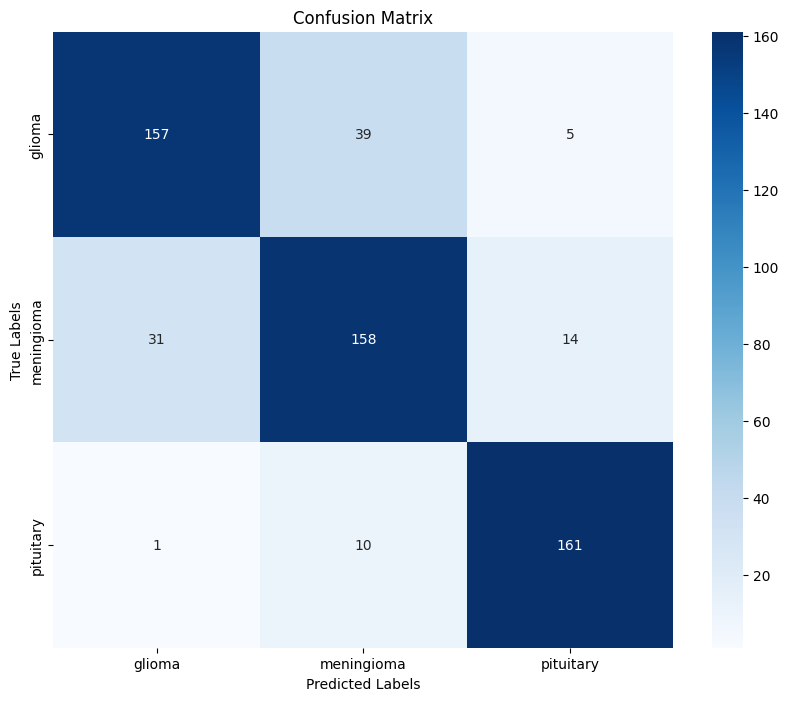

In [6]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# y_pred = loaded_model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# conf_matrix = confusion_matrix(y_test, y_pred_classes)

# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()


In [ ]:
# import os
# import cv2
# import numpy as np
# from sklearn.model_selection import train_test_split
# import tensorflow as tf
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
# from keras.applications.resnet_v2 import ResNet152V2, preprocess_input
# from keras.optimizers import Adam
# from keras.regularizers import l2

# base_dir = 'C:/brain_tumor/version2/notebook/Training'
# class_names = ['glioma', 'meningioma', 'pituitary']

# X = []
# y = []

# for label, class_name in enumerate(class_names):
#     class_dir = os.path.join(base_dir, class_name)
#     for img_name in os.listdir(class_dir):
#         img_path = os.path.join(class_dir, img_name)
#         img = cv2.imread(img_path)
#         img = cv2.resize(img, (128, 128))
#         X.append(img)
#         y.append(label)

# X = np.array(X)
# y = np.array(y)

# X = X.astype('float32') / 255.0

# base_model = ResNet152V2(weights='imagenet', include_top=False)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = Dropout(0.6)(x)  
# predictions = Dense(len(class_names), activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# for layer in base_model.layers:
#     layer.trainable = False

# model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# X_final, X_val, y_final, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# history = model.fit(
#     X_final, y_final,
#     epochs=100,
#     validation_data=(X_val, y_val),
#     batch_size=4
# )

In [ ]:
# model.save('resnet_case_1.h5')

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

In [ ]:
# import os
# import cv2
# import numpy as np
# from sklearn.model_selection import train_test_split
# import tensorflow as tf
# from keras.preprocessing.image import ImageDataGenerator
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
# from keras.applications.resnet_v2 import ResNet152V2, preprocess_input
# from keras.optimizers import Adam
# from keras.regularizers import l2

# base_dir = 'C:/brain_tumor/version2/notebook/Training'
# class_names = ['glioma', 'meningioma', 'pituitary']

# X = []
# y = []

# for label, class_name in enumerate(class_names):
#     class_dir = os.path.join(base_dir, class_name)
#     for img_name in os.listdir(class_dir):
#         img_path = os.path.join(class_dir, img_name)
#         img = cv2.imread(img_path)
#         img = cv2.resize(img, (128, 128))
#         X.append(img)
#         y.append(label)

# X = np.array(X)
# y = np.array(y)

# X = X.astype('float32') / 255.0

# # Data augmentation setup
# datagen = ImageDataGenerator(horizontal_flip=True, height_shift_range=0.2, zoom_range=0.2)

# # Generate 200 augmented images for each class
# X_augmented = []
# y_augmented = []
# for class_name in class_names:
#     class_idx = class_names.index(class_name)
#     class_images = X_train[y_train == class_idx]
#     class_labels = y_train[y_train == class_idx]
    
#     augmented_images = datagen.flow(class_images, class_labels, batch_size=1, shuffle=False)
    
#     for _ in range(200):
#         aug_img, aug_label = augmented_images.next()
#         X_augmented.append(aug_img[0])
#         y_augmented.append(aug_label[0])

# X_augmented = np.array(X_augmented)
# y_augmented = np.array(y_augmented)

# X_combined = np.concatenate((X_train, X_augmented), axis=0)
# y_combined = np.concatenate((y_train, y_augmented), axis=0)

# X_final, X_val, y_final, y_val = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# base_model = ResNet152V2(weights='imagenet', include_top=False)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = Dropout(0.6)(x)  
# predictions = Dense(len(class_names), activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# for layer in base_model.layers:
#     layer.trainable = False

# model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# history = model.fit(
#     X_final, y_final,
#     epochs=100,
#     validation_data=(X_val, y_val),
#     batch_size=4
# )

In [ ]:
# model.save('resnet_case_2.h5')

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

In [ ]:
# import os
# import cv2
# import numpy as np
# from sklearn.model_selection import train_test_split
# import tensorflow as tf
# from keras.preprocessing.image import ImageDataGenerator
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
# from keras.applications.resnet_v2 import ResNet152V2, preprocess_input
# from keras.optimizers import Adam
# from keras.regularizers import l2

# base_dir = 'C:/brain_tumor/version2/notebook/Training'
# gen_dir = 'C:/brain_tumor/version2/notebook/generated_dataset'
# class_names = ['glioma', 'meningioma', 'pituitary']

# X = []
# y = []
# X_generated = []
# y_generated = []

# for label, class_name in enumerate(class_names):
#     class_dir = os.path.join(base_dir, class_name)
#     gen_class_dir = os.path.join(gen_dir, class_name)
#     for img_name in os.listdir(class_dir):
#         img_path = os.path.join(class_dir, img_name)
#         img = cv2.imread(img_path)
#         img = cv2.resize(img, (128, 128))
#         X.append(img)
#         y.append(label)
#     for image_name in os.listdir(gen_class_dir):
#         image_path = os.path.join(gen_class_dir, image_name)
#         image = cv2.imread(image_path)
#         image = cv2.resize(image, (128, 128))
#         X_generated.append(image)
#         y_generated.append(label)

# X = np.array(X)
# y = np.array(y)
# X_generated = np.array(X_generated)
# y_generated = np.array(y_generated)

# X = X.astype('float32') / 255.0
# X_generated = X_generated.astype('float32') / 255.0

# X_train = np.array([preprocess_input(cv2.resize(img, (128, 128))) for img in X_train])
# X_test = np.array([preprocess_input(cv2.resize(img, (128, 128))) for img in X_test])
# X_generated = np.array([preprocess_input(cv2.resize(img, (128, 128))) for img in X_generated])

# X_train_combined = np.concatenate((X_train, X_generated), axis=0)
# y_train_combined = np.concatenate((y_train, y_generated), axis=0)

# shuffle_indices = np.random.permutation(len(X_train_combined))
# X_train_combined_shuffled = X_train_combined[shuffle_indices]
# y_train_combined_shuffled = y_train_combined[shuffle_indices]

# base_model = ResNet152V2(weights='imagenet', include_top=False)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = Dropout(0.6)(x)  
# predictions = Dense(len(class_names), activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# for layer in base_model.layers:
#     layer.trainable = False

# X_final, X_val, y_final, y_val = train_test_split(X_train_combined_shuffled, y_train_combined_shuffled, test_size=0.2, random_state=42)

# model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# history = model.fit(
#     X_final, y_final,
#     epochs=100,
#     validation_data=(X_val, y_val),
#     batch_size=4
# )

In [ ]:
# model.save('resnet_case_3.h5')

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()